# Main Notebook

## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from src.data_utils.dataloader import PokemonDataset, PokemonFusionDataset, ResizeSprite
from src.data_utils.metadata import PokemonMetaData
from src.main import build_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

## Datasets

### Pokemon Types (label)

We have obtained labels from: 
https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6/archive/92200bc0a673d5ce2110aaad4544ed6c4010f687.zip

Which we have also loaded in a Metadata class as seen below. Here we have made the translation from Pokemon ID to type.

In [2]:
metadata = PokemonMetaData()

print("Available types:")
print(list(metadata.types_dict.keys()))

# convert id to type
print("\nPokemon with ID 1 is of type: ", metadata.get_type_by_id(1, numeric=False))
# NOTE This method is used within the dataloaders when creating the label

# convert type to id
label_to_idx = metadata.types_dict
# flip the dictionary
idx_to_label = {v: k for k, v in label_to_idx.items()}

Available types:
['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

Pokemon with ID 1 is of type:  Grass


### Original dataset

Our original dataset consists of multiple game generation Pokemon sprites. We have made a dataloader class to load the games and whether we want front facing, back facing or shiny.

First we explore the resolutions of the different generations:

In [3]:
def print_stats(game: str):
    root_dir = "data/raw"
    dataset = PokemonDataset(root_dir, labels=["front", "shiny"], games=[game], transform=None)

    image = dataset[0][0]
    print("   Image shape: ", image.shape)
    print("   Total images: ", len(dataset))
    
print("Generation 1")
print_stats("yellow")

print("\n * Generation 1 (Fire Red/Leaf Green)")
print_stats("firered-leafgreen")

print("\nGeneration 2 (Silver)")
print_stats("silver")

print("\n * Generation 2 (Heart Gold)")
print_stats("heartgold-soulsilver")

print("\n * Generation 3")
print_stats("emerald")

print("\n * Generation 4")
print_stats("diamond-pearl")

print("\nGeneration 5")
print_stats("black-white")

Generation 1
   Image shape:  torch.Size([3, 40, 40])
   Total images:  151

 * Generation 1 (Fire Red/Leaf Green)
   Image shape:  torch.Size([3, 64, 64])
   Total images:  306

Generation 2 (Silver)
   Image shape:  torch.Size([3, 40, 40])
   Total images:  502

 * Generation 2 (Heart Gold)
   Image shape:  torch.Size([3, 80, 80])
   Total images:  986

 * Generation 3
   Image shape:  torch.Size([3, 64, 64])
   Total images:  772

 * Generation 4
   Image shape:  torch.Size([3, 80, 80])
   Total images:  986

Generation 5
   Image shape:  torch.Size([3, 96, 96])
   Total images:  1298


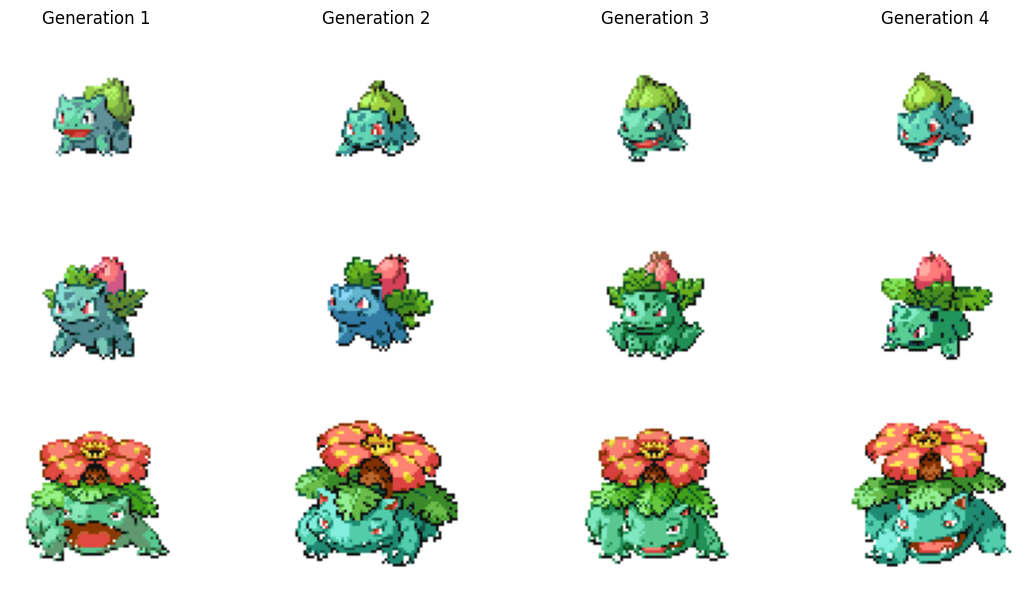

In [27]:
# Here we just plot the three datasets we decided to use with the transformations we made. See report and main.py for more details
transform = [transforms.ToTensor()]

t1 = [transforms.Pad(4, fill=255, padding_mode='constant'), ResizeSprite((64, 64))]
t1.extend(transform)
t2 = [ResizeSprite((64, 64))]
t2.extend(transform)


gen1_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["firered-leafgreen"], transform=transforms.Compose(t1))
gen2_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["heartgold-soulsilver"], transform=transforms.Compose(t2))
gen3_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["emerald"], transform=transforms.Compose(t1))
gen4_dataset = PokemonDataset("data/raw", labels=["front", "shiny"], games=["diamond-pearl"], transform=transforms.Compose(t2))

# plot first 3 images from each
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
axs[0, 0].set_title("Generation 1")
axs[0, 1].set_title("Generation 2")
axs[0, 2].set_title("Generation 3")
axs[0, 3].set_title("Generation 4")

for i in range(3):
    axs[i, 0].imshow(gen1_dataset[i][0].permute(1, 2, 0))
    axs[i, 1].imshow(gen2_dataset[i][0].permute(1, 2, 0))
    axs[i, 2].imshow(gen3_dataset[i][0].permute(1, 2, 0))
    axs[i, 3].imshow(gen4_dataset[i][0].permute(1, 2, 0))
# remove axis
for ax in axs.flatten():
    ax.axis('off')

plt.tight_layout()

plt.savefig("figures/orig_dataset_comparison.pdf", format="pdf", dpi=300, bbox_inches='tight')

 We have only included front and shiny sprites from the games "emerald", "firered-leafgreen", "diamond-pearl", and "heartgold-soulsilver".
 Some randomly shuffled samples are plotted below from this subset which is our final original dataset. Se the report or the build_dataset class for details on how we resized the images ot 64x64.

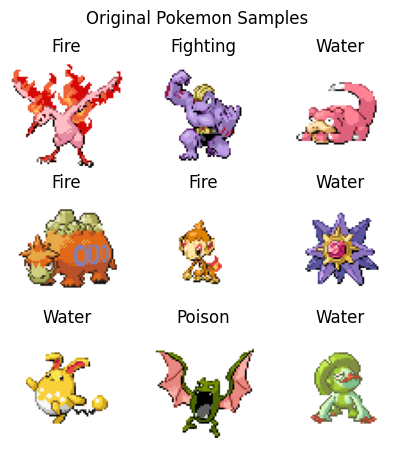

In [18]:
# Build the two datasets. See build dataset for transformation details
orig_data = build_dataset("original")
# Make dataloader
orig_loader = DataLoader(orig_data, batch_size=9, shuffle=True)

# Get the first batch of images and labels
orig_batch_imgs, orig_batch_labels = next(iter(orig_loader))

# plot in two 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(5, 5))
axs = axs.flatten()

# plot original images
for i in range(len(orig_batch_imgs)):
    img = orig_batch_imgs[i].permute(1, 2, 0)
    axs[i].imshow(img)
    lab = orig_batch_labels[i].item()
    axs[i].set_title(idx_to_label[lab])
    axs[i].axis("off")

plt.suptitle("Original Pokemon Samples")
# save to figure
plt.savefig("figures/original_dataset_samples.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

### Fusion dataset

We have scraped additional fan made Pokemon fusions from: https://fusioncalc.com/. Here we only scrape fusions between Pokemon of the same type.

We have already scraped the data and it can be downloaded from our GDrive with the following make command:

In [ ]:
# Run make command to download the dataset
!make get-fusion-data

Alternatively the data can be scraped using (!!be aware that you will be making around 6000 queries to the website!!):

In [ ]:
!make scrape-fusion-data

Some Fusion dataset samples are plotted below

Fused images have resolution:  torch.Size([3, 64, 64])


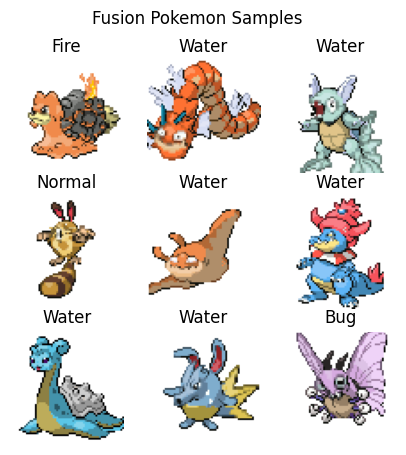

In [32]:
# Build the dataset with our method from main.py
fusion_data = build_dataset("fusion")

# Create a dataloader with batch size 9 for visualization
fusion_loader = DataLoader(fusion_data, batch_size=9, shuffle=True)

# Get a batch of data
fusion_batch_imgs, fusion_batch_labels = next(iter(fusion_loader))

# plot in two 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(5,5))
axs = axs.flatten()

# plot original images
for i in range(len(fusion_batch_imgs)):
    img = fusion_batch_imgs[i].permute(1, 2, 0)
    axs[i].imshow(img)
    lab = fusion_batch_labels[i].item()
    axs[i].set_title(idx_to_label[lab])
    axs[i].axis("off")

plt.suptitle("Fusion Pokemon Samples")
# save to figure for report
plt.savefig("figures/fusion_dataset_samples.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)


# resolution of fused images
print("Fused images have resolution: ", fusion_batch_imgs[0].shape)

### Our final Dataloader

These two dataset are merged into one, which we have done in main.py

Text(0.5, 0.98, 'Final Dataset Samples')

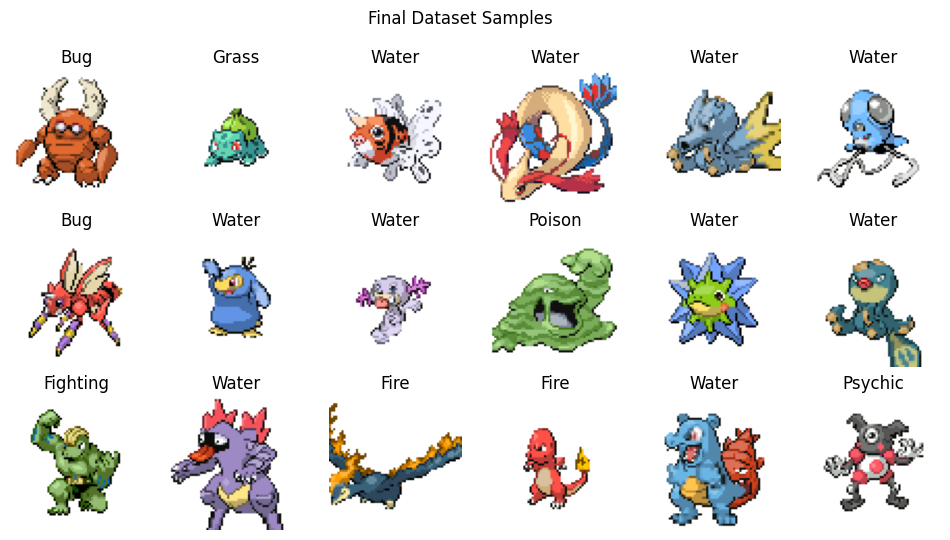

In [34]:
final_dataset = build_dataset("all")


# Create a dataloader with batch size 9 for visualization
final_loader = DataLoader(final_dataset, batch_size=18, shuffle=True)

# Get a batch of data
final_batch_imgs, final_batch_labels = next(iter(final_loader))

# plot in two 3x3 grid
fig, axs = plt.subplots(3, 6, figsize=(12,6))
axs = axs.flatten()

# plot original images
for i in range(len(final_batch_imgs)):
    img = final_batch_imgs[i].permute(1, 2, 0)
    axs[i].imshow(img)
    lab = final_batch_labels[i].item()
    axs[i].set_title(idx_to_label[lab])
    axs[i].axis("off")

plt.suptitle("Final Dataset Samples")

In [42]:
print("Total number of images in final dataset: ", len(final_dataset))

Total number of images in final dataset:  8385


### Type distribution

In [39]:
# count each type in the final dataset

type_counts = {k: 0 for k in metadata.types_dict.keys()}
for _, lab in final_dataset:
    type_counts[idx_to_label[lab]] += 1

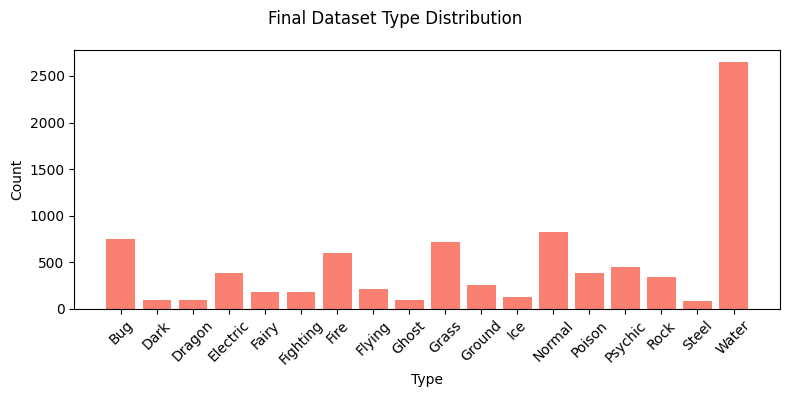

In [41]:
# make histogram
fig, ax = plt.subplots()
ax.bar(type_counts.keys(), type_counts.values(), color="salmon")
ax.set_ylabel("Count")
ax.set_xlabel("Type")
plt.xticks(rotation=45)

# figsize for report
plt.gcf().set_size_inches(8, 4)

plt.suptitle("Final Dataset Type Distribution")
plt.tight_layout()
plt.savefig("figures/type_dist.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

## Modeling